In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def PlotModel(model, pdf, features, cutoff, filename):
    
    params = {'axes.labelsize': 18,
            'axes.linewidth' : 1.5,
            'font.size': 18,
            'font.family': 'Times New Roman',
            'mathtext.fontset': 'stix',
            'legend.fontsize': 20,
            'xtick.labelsize': 18,
            'ytick.labelsize': 20,
            'text.usetex': False,
            'lines.linewidth': 1,
            'lines.linestyle': ' ',
            'lines.markersize' : 6,
            'lines.markeredgewidth' : 1,
            'xtick.major.size' : 5,
            'xtick.minor.size' : 3,
            'xtick.major.width' : 2,
            'xtick.minor.width' : 1,
            'xtick.direction' : 'in',
            'ytick.major.size' : 5,
            'ytick.minor.size' : 3,
            'ytick.major.width' : 2,
            'ytick.minor.width' : 1,
            'ytick.direction' : 'in',
            'xtick.minor.visible' : True,
            'ytick.minor.visible' : True,
            'figure.figsize': (8,6),
            'savefig.transparent': True,
            'errorbar.capsize': 1.5,
            }
    plt.rcParams.update(params)
    
    
    num_layers = len(model.layers)
    print('Number of layers: ', num_layers)
    layers = []
    for i in range(num_layers):
            layers.append(model.get_layer(index=i))

    layerX = {}
    layerY = {}
    layerOutput = {}
    layerProbability = {}
    layerWeights = {}
    layerBias = {}
    layerNactive = {}

    ymin = 1
    ymax = 2000
    nsamples = pdf.shape[0]
    X = pdf[features].values
    InputX = np.ones(X.shape[1])
    InputY = np.linspace(ymin,ymax,X.shape[1])
    InputProbability = np.ones(X.shape[1])
    for i in range(num_layers):
            layerWeights[i] = layers[i].get_weights()[0]
            layerBias[i] = layers[i].get_weights()[1]
            layerX[i] = np.ones(layerWeights[i].shape[1])*(i+2)
            if i == num_layers-1:
                    layerY[i] = np.array([(ymax-ymin)/2])
            else:
                    layerY[i] = np.linspace(ymin,ymax,layerWeights[i].shape[1])
            if i == 0:
                    layerOutput[i] = layers[i](X)
            else:
                    layerOutput[i] = layers[i](layerOutput[i-1])
                    
            layerProbability[i] = np.sum(layerOutput[i]>cutoff, axis=0)/nsamples
            layerNactive[i] = np.count_nonzero(layerProbability[i])

    fig = plt.figure(figsize=(15,20))
    ax = fig.add_subplot(111)        

    for ilayer in range(num_layers):
            for i in range(layerWeights[ilayer].shape[0]):
                    for j in range(layerWeights[ilayer].shape[1]):
                                    if ilayer == 0:
                                            if layerProbability[ilayer][j] > cutoff:
                                                    ax.plot([InputX[i]+0.02, layerX[ilayer][j]-0.02], [InputY[i], layerY[ilayer][j]], linewidth=0.5,
                                                            c=cm.Blues(np.abs(layerWeights[ilayer][i,j])/np.max(np.abs(layerWeights[ilayer][:,j]))), linestyle='-', alpha=0.7)
                                    else:
                                            if layerProbability[ilayer][j] > cutoff:
                                                    ax.plot([layerX[ilayer-1][i]+0.02, layerX[ilayer][j]-0.02], [layerY[ilayer-1][i], layerY[ilayer][j]], linewidth=0.5,
                                                            c=cm.Blues(np.abs(layerWeights[ilayer][i,j])/np.max(np.abs(layerWeights[ilayer][:,j]))), linestyle='-', alpha=0.7)
                                    
    ax.scatter(InputX, InputY, s=30, c=InputProbability, cmap='Reds', alpha=1.0, vmin=0, vmax=1)
    for i in range(num_layers):
            ax.scatter(layerX[i][layerProbability[i] > cutoff], layerY[i][layerProbability[i] > cutoff], s=30, c=layerProbability[i][layerProbability[i]>cutoff], cmap='Reds', alpha=1.0, vmin=0, vmax=1)
            
    ax.set_xlim(0.8, num_layers+1.2)
    xticks = [i+1 for i in range(num_layers+1)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['Input']+['Layer '+str(i+1) for i in range(0,num_layers-1)]+['Output'])
    ax.set_ylim(ymin-200,ymax+200)
    ax.set_yticks(InputY)
    top_features_tex = [r'$\lambda_{\beta=1}$', r'$A_{\mathrm{jet}}$', r'$p_{\mathrm{T,raw}}$', r'$N_{\mathrm{track}}$', r'$p_{\mathrm{T,track}}^{0}$']
    ax.set_yticklabels(top_features_tex)
    ax.cbar = plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap='Reds'), ax=ax, location='top', pad=0.1, aspect=50, anchor=(0.5,-0.7))
    ax.cbar.set_label('Probability of Neuron Activation', rotation=0, labelpad=10)
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
    ax2.set_yticks(layerY[num_layers-1])
    ax2.set_yticklabels([r'$p_{\mathrm{T,truth}}$'])
    ax2.cbar = plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap='Blues'), ax=ax2, location='bottom', pad=0.1, aspect=50, anchor=(0.5,1.5))
    ax2.cbar.set_label('Normalized Weights', rotation=0, labelpad=10)
    plt.show()
    
    active_nodes = []
    for i in range(num_layers):
            active_nodes.append(layerNactive[i])
    fig.savefig(f'plots/{filename}.pdf', bbox_inches='tight')
    return active_nodes

def GetPlot(model_results, features):
        ymin = 1
        ymax = 2000
        layerX = [np.ones(len(features))]
        layerY = [np.linspace(ymin,ymax,len(features))]
        layer_probabilities = [np.ones(len(features))]
        layer_weights = []
        for i in range(len(model_results['activation_prob'])):
                layer_probabilities.append(model_results['activation_prob'][i])
                layer_weights.append(model_results['weights'][i])
                layerX.append(np.ones(len(model_results['activation_prob'][i]))*(i+2))
                if i == len(model_results['activation_prob'])-1:
                        layerY.append(np.array([(ymax-ymin)/2]))
                else:
                        layerY.append(np.linspace(ymin,ymax,len(model_results['activation_prob'][i])))

        line_iXY = []
        line_fXY = []
        line_W = []
        node_XY = []
        node_W = []

        cutoff = 0.0
        for iW, w in enumerate(layer_weights):
                for iY, iprob in enumerate(layer_probabilities[iW]):
                        if iprob > cutoff:
                                node_XY.append([layerX[iW][iY],layerY[iW][iY]])
                                node_W.append(layer_probabilities[iW][iY])
                                for jY, jprob in enumerate(layer_probabilities[iW+1]):
                                        if jprob > cutoff:
                                                node_XY.append([layerX[iW+1][jY],layerY[iW+1][jY]])
                                                node_W.append(layer_probabilities[iW+1][jY])
                                                line_iXY.append([layerX[iW][iY],layerY[iW][iY]])
                                                line_fXY.append([layerX[iW+1][jY],layerY[iW+1][jY]])
                                                line_W.append(np.abs(w[iY,jY]/np.max(np.abs(w[:,jY]))))    
        line_iXY = np.array(line_iXY)
        line_fXY = np.array(line_fXY)
        line_W = np.array(line_W)
        node_XY = np.array(node_XY)
        node_W = np.array(node_W)
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)   
        for A, B, W in zip(line_iXY, line_fXY, line_W):
                ax.plot([A[0]+0.03, B[0]-0.03], [A[1], B[1]], c=cm.Blues(W), linewidth=0.5, alpha=0.5)
        ax.scatter(node_XY[:,0],node_XY[:,1],c=node_W,cmap=cm.Reds,s=30,alpha=1.0)
        # plt.show()
        
        Plot = {}
        Plot['iXY'] = line_iXY
        Plot['fXY'] = line_fXY
        Plot['lineW'] = line_W
        Plot['nodeXY'] = node_XY
        Plot['nodeW'] = node_W
        
        return Plot

def PruneModel(model,pdf_file, features, target):
        # probability cutoff
        pdf =  pd.read_hdf(pdf_file, key='df')
        cutoff = 0.0
        model.summary()
        model.compile(loss='mse', optimizer='adam', metrics=['mse'])
        model.fit(pdf[features].values, pdf[target].values, epochs=25, batch_size=128, verbose=1, validation_split=0.2)

        layer_in_model = []
        for i in range(len(model.layers)):
                layer_in_model.append(model.get_layer(index=i))

        X = pdf[features].values 
        layer_activation_probabilities = {}
        layer_weights = {}
        layer_biases = {}
        weights_for_plot = []
        for i in range(len(layer_in_model)):
                
                layer_outputs = layer_in_model[i](X)
                layer_activation_probabilities[i] = np.count_nonzero(np.array(layer_outputs), axis=0)/X.shape[0]
                layer_weights[i] = layer_in_model[i].get_weights()[0]
                layer_biases[i] = layer_in_model[i].get_weights()[1]
                weights_for_plot.append(layer_weights[i])
                for j in range(layer_activation_probabilities[i].shape[0]):
                        if layer_activation_probabilities[i][j] <= cutoff:
                                        layer_weights[i][:,j] = 0.0
                                        layer_biases[i][j] = 0.0
                X = layer_in_model[i](X)   
                
        for i in range(1,len(layer_in_model)):
                for j in range(layer_activation_probabilities[i-1].shape[0]):
                        if layer_activation_probabilities[i-1][j] <= cutoff:
                                        layer_weights[i][j,:] = 0.0                               

        new_weights = {}
        new_biases = {}
        for i in range(1,len(layer_in_model)):
                weights = []
                bias = []
                for j in range(layer_weights[i].shape[0]):
                        w = layer_weights[i][j,:]
                        w = w[w != 0.0]
                        if w.size != 0:
                                weights.append(w)
                for j in range(layer_biases[i].shape[0]):
                        b = layer_biases[i][j]
                        if b != 0.0:
                                bias.append(b)
                                
                new_weights[i] = np.array(weights)
                new_biases[i] = np.array(bias)
                
        active_nodes = []
        for i in range(len(layer_in_model)):
                if np.count_nonzero(layer_activation_probabilities[i])  == 0:
                        active_nodes.append(1)
                else: 
                        active_nodes.append(np.count_nonzero(layer_activation_probabilities[i]))

        weights_for_new_model = []
        bias_for_new_model = []
        for w in new_weights:
                weights_for_new_model.append(new_weights[w])
                bias_for_new_model.append(new_biases[w])

        weights_for_plot = []
        for w in layer_weights:
                weights_for_plot.append(layer_weights[w])

        nodes_for_new_model = active_nodes 
        layer_activation_probabilities_for_plot = []
        for i in range(len(layer_in_model)):
                layer_activation_probabilities_for_plot.append(layer_activation_probabilities[i])
                
        mse_of_model = model.evaluate(pdf[features], pdf[target], verbose=0)[1]
        print('MSE of model: ', mse_of_model)   

        model_results = {}
        model_results['mse'] = mse_of_model
        model_results['activation_prob'] = layer_activation_probabilities_for_plot
        model_results['weights'] = weights_for_plot
        
        new_model = {}
        new_model['weights'] = weights_for_new_model
        new_model['bias'] = bias_for_new_model
        new_model['nodes'] = nodes_for_new_model
        
        return model_results, new_model

In [11]:
def GetDNNPlot():
    filename = "/lustre/isaac/scratch/tmengel/jet-background-subtraction/datasets/root-files/AuAu_R04/test/AuAu_R04_50_test_sample.h5"
    dnn_features = ["jet_pt_raw","jet_nparts","jet_area","jet_angularity","jet_track_pt_0",
                            "jet_track_pt_1","jet_track_pt_2","jet_track_pt_3","jet_track_pt_4",
                            "jet_track_pt_5","jet_track_pt_6","jet_track_pt_7"]
    dnn_features_tex =  [r'$p_{\mathrm{T,raw}}$',  r'$N_{\mathrm{track}}$', r'$A_{\mathrm{jet}}$', r'$\lambda_{\alpha=1}$', r'$p_{\mathrm{T,track}}^{0}$',
                            r'$p_{\mathrm{T,track}}^{1}$', r'$p_{\mathrm{T,track}}^{2}$', r'$p_{\mathrm{T,track}}^{3}$', r'$p_{\mathrm{T,track}}^{4}$',
                            r'$p_{\mathrm{T,track}}^{5}$', r'$p_{\mathrm{T,track}}^{6}$', r'$p_{\mathrm{T,track}}^{7}$']
    target='jet_pt_truth'
    n_layers_initial = 4
    n_nodes_initial = [100,100,50,1]
    layer_list = []
    for i in range(n_layers_initial):
            layer_list.append(tf.keras.layers.Dense(n_nodes_initial[i],input_shape=(len(dnn_features),),activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
    model = keras.Sequential(layer_list)
    model_results, new_model = PruneModel(model,filename,features=dnn_features,target=target)
    PLOTS = GetPlot(model_results, dnn_features)
    
    return PLOTS

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               1300      
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 16,501
Trainable params: 16,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6250/6250 [==============================] - 10s 1ms/step - loss: 3.5884 - mse: 3.3063 - val_loss: 2.8773 - val_mse: 2.6208
Epoch 2/25
6250/6250 [=========================

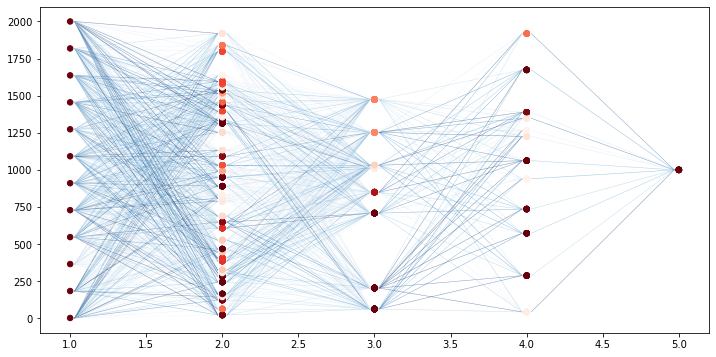

In [12]:
filename = "/lustre/isaac/scratch/tmengel/jet-background-subtraction/datasets/root-files/AuAu_R04/test/AuAu_R04_50_test_sample.h5"
dnn_features = ["jet_pt_raw","jet_nparts","jet_area","jet_angularity","jet_track_pt_0",
                        "jet_track_pt_1","jet_track_pt_2","jet_track_pt_3","jet_track_pt_4",
                        "jet_track_pt_5","jet_track_pt_6","jet_track_pt_7"]
dnn_features_tex =  [r'$p_{\mathrm{T,raw}}$',  r'$N_{\mathrm{track}}$', r'$A_{\mathrm{jet}}$', r'$\lambda_{\alpha=1}$', r'$p_{\mathrm{T,track}}^{0}$',
                        r'$p_{\mathrm{T,track}}^{1}$', r'$p_{\mathrm{T,track}}^{2}$', r'$p_{\mathrm{T,track}}^{3}$', r'$p_{\mathrm{T,track}}^{4}$',
                        r'$p_{\mathrm{T,track}}^{5}$', r'$p_{\mathrm{T,track}}^{6}$', r'$p_{\mathrm{T,track}}^{7}$']
target='jet_pt_truth'
target_tex = r'$p_{\mathrm{T,truth}}$'

ALLPLOTS = {}
ALLPLOTS['dnn'] = GetDNNPlot()

In [39]:
def PruneSNNModel(n_layers_initial=4, n_nodes_initial=[100,100,100,1]):
        features=['jet_angularity', 'jet_area', 'jet_pt_raw',  'jet_nparts', 'jet_track_pt_0']
        target='jet_pt_truth'
        filename = "/lustre/isaac/scratch/tmengel/jet-background-subtraction/datasets/root-files/AuAu_R04/test/AuAu_R04_50_test_sample.h5"
     
        layer_list = []
        for i in range(n_layers_initial):
                layer_list.append(tf.keras.layers.Dense(n_nodes_initial[i],input_shape=(len(features),),activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
        model = keras.Sequential(layer_list)
        PLOTS = {}
        model_results, new_model = PruneModel(model,filename,features=features,target=target)
        PLOTS["iteration0"] = GetPlot(model_results,features)

        # n_layers = len(new_model['nodes'])
        # nodes =[]
        # nlayers =1
        # for j in range(len(new_model['nodes'])-1):
        #         if new_model['nodes'][j] > 1:
        #                 nodes.append(new_model['nodes'][j])
        #                 nlayers +=1
        #         else:
        #                 nodes[-1] += new_model['nodes'][j]
        # nodes.append(1)
        # print(nodes)
        # print(nlayers)
                
                        
        # layer_list = []
        # for i in range(n_layers):
        #         layer_list.append(tf.keras.layers.Dense(new_model['nodes'][i],input_shape=(len(features),),activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
        # model = keras.Sequential(layer_list)
        
        # model_results, new_model = PruneModel(model,filename,features,target)
        # tmpplot = GetPlot(model_results,features)
        # PLOTS["iteration1"] = tmpplot
        
        # n_layers = len(new_model['nodes'])
        # nodes =[]
        # nlayers =1
        # for j in range(len(new_model['nodes'])-1):
        #         if new_model['nodes'][j] > 1:
        #                 nodes.append(new_model['nodes'][j])
        #                 nlayers +=1
        #         else:
        #                 nodes[-1] += new_model['nodes'][j]
        # nodes.append(1)
        # print(nodes)
        # print(nlayers)
                
                        
        # layer_list = []
        # for i in range(n_layers):
        #         layer_list.append(tf.keras.layers.Dense(new_model['nodes'][i],input_shape=(len(features),),activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
        # model = keras.Sequential(layer_list)
        
        # model_results, new_model = PruneModel(model,filename,features,target)
        # tmpplot = GetPlot(model_results,features)
        # PLOTS["iteration2"] = tmpplot
        
        # n_layers = len(new_model['nodes'])
        # nodes =[]
        # nlayers =1
        # for j in range(len(new_model['nodes'])-1):
        #         if new_model['nodes'][j] > 1:
        #                 nodes.append(new_model['nodes'][j])
        #                 nlayers +=1
        #         else:
        #                 nodes[-1] += new_model['nodes'][j]
        # nodes.append(1)
        # print(nodes)
        # print(nlayers)
        
        # layer_list = []
        # for i in range(n_layers):
        #         layer_list.append(tf.keras.layers.Dense(new_model['nodes'][i],input_shape=(len(features),),activation='relu',kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.001)))
                
        # model = keras.Sequential(layer_list)
        
        # model_results, new_model = PruneModel(model,filename,features,target)
        # tmpplot = GetPlot(model_results,features)
        # PLOTS["iteration3"] = tmpplot
        
        
        

        return PLOTS


In [33]:
PLOTSSNN = PruneSNNModel()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 100)               600       
                                                                 
 dense_95 (Dense)            (None, 100)               10100     
                                                                 
 dense_96 (Dense)            (None, 100)               10100     
                                                                 
 dense_97 (Dense)            (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
  73/6250 [..............................] - ETA: 8s - loss: 52.5750 - mse: 52.0414    

KeyboardInterrupt: 

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 20)                120       
                                                                 
 dense_99 (Dense)            (None, 16)                336       
                                                                 
 dense_100 (Dense)           (None, 1)                 17        
                                                                 
Total params: 473
Trainable params: 473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6250/6250 [==============================] - 6s 965us/step - loss: 11.6106 - mse: 11.5651 - val_loss: 3.6022 - val_mse: 3.5574
Epoch 2/25
6250/6250 [==============================] - 6s 931us/step - loss: 3.6173 - mse: 3.5713 - val_loss: 3.5235 - val_mse: 3.4773
Epoch 3/25
6250/6250 [=======================

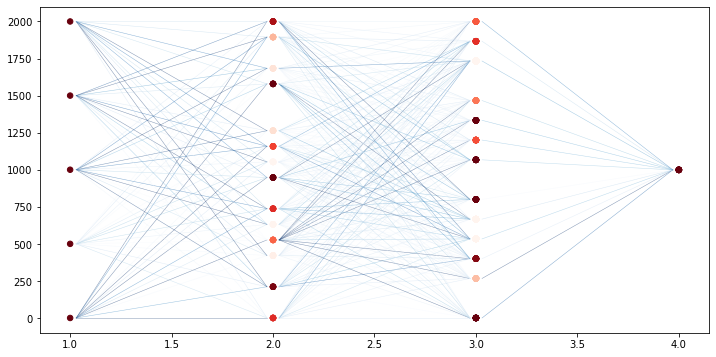

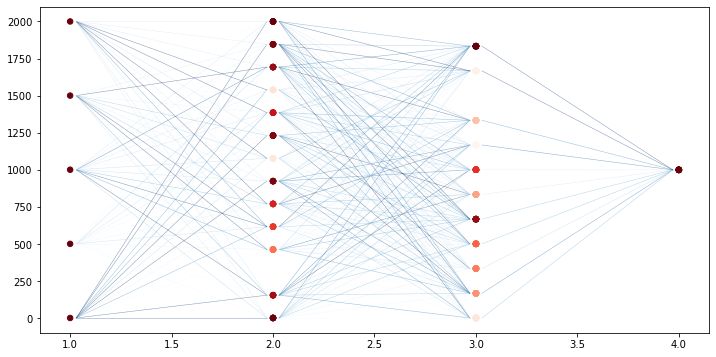

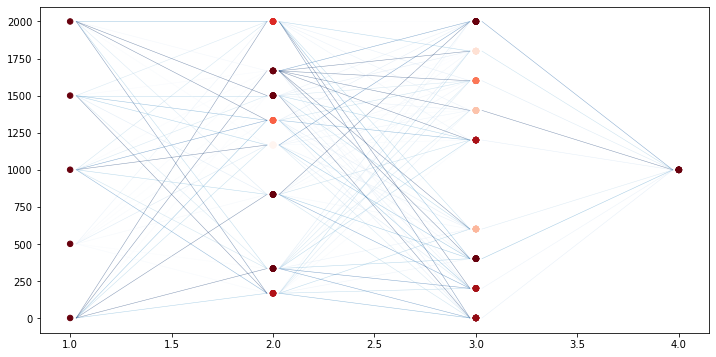

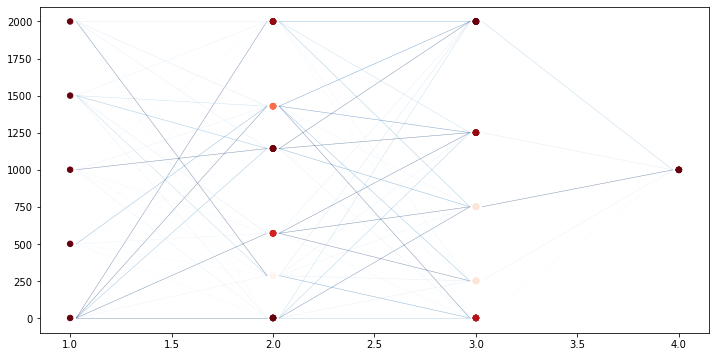

In [35]:
PLOTSSN3LAYERS = PruneSNNModel(n_layers_initial=3, n_nodes_initial=[20, 16, 1])

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 6)                 36        
                                                                 
 dense_121 (Dense)           (None, 1)                 7         
                                                                 
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6250/6250 [==============================] - 7s 1ms/step - loss: 212.4668 - mse: 212.4620 - val_loss: 3.7212 - val_mse: 3.7155
Epoch 2/25
6250/6250 [==============================] - 7s 1ms/step - loss: 3.7509 - mse: 3.7450 - val_loss: 3.7058 - val_mse: 3.6996
Epoch 3/25
6250/6250 [==============================] - 5s 865us/step - loss: 3.7445 - mse: 3.7381 - val_loss: 3.7523 - val_mse: 3.7457
Epoch 4/25
6250/6250 [=======================

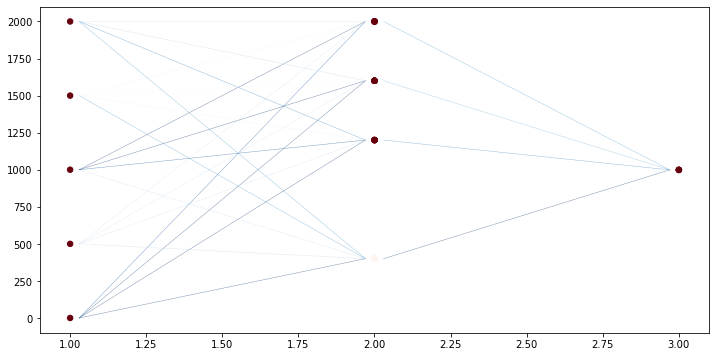

In [40]:
PLOTSSN2LAYERS = PruneSNNModel(n_layers_initial=2, n_nodes_initial=[6, 1])

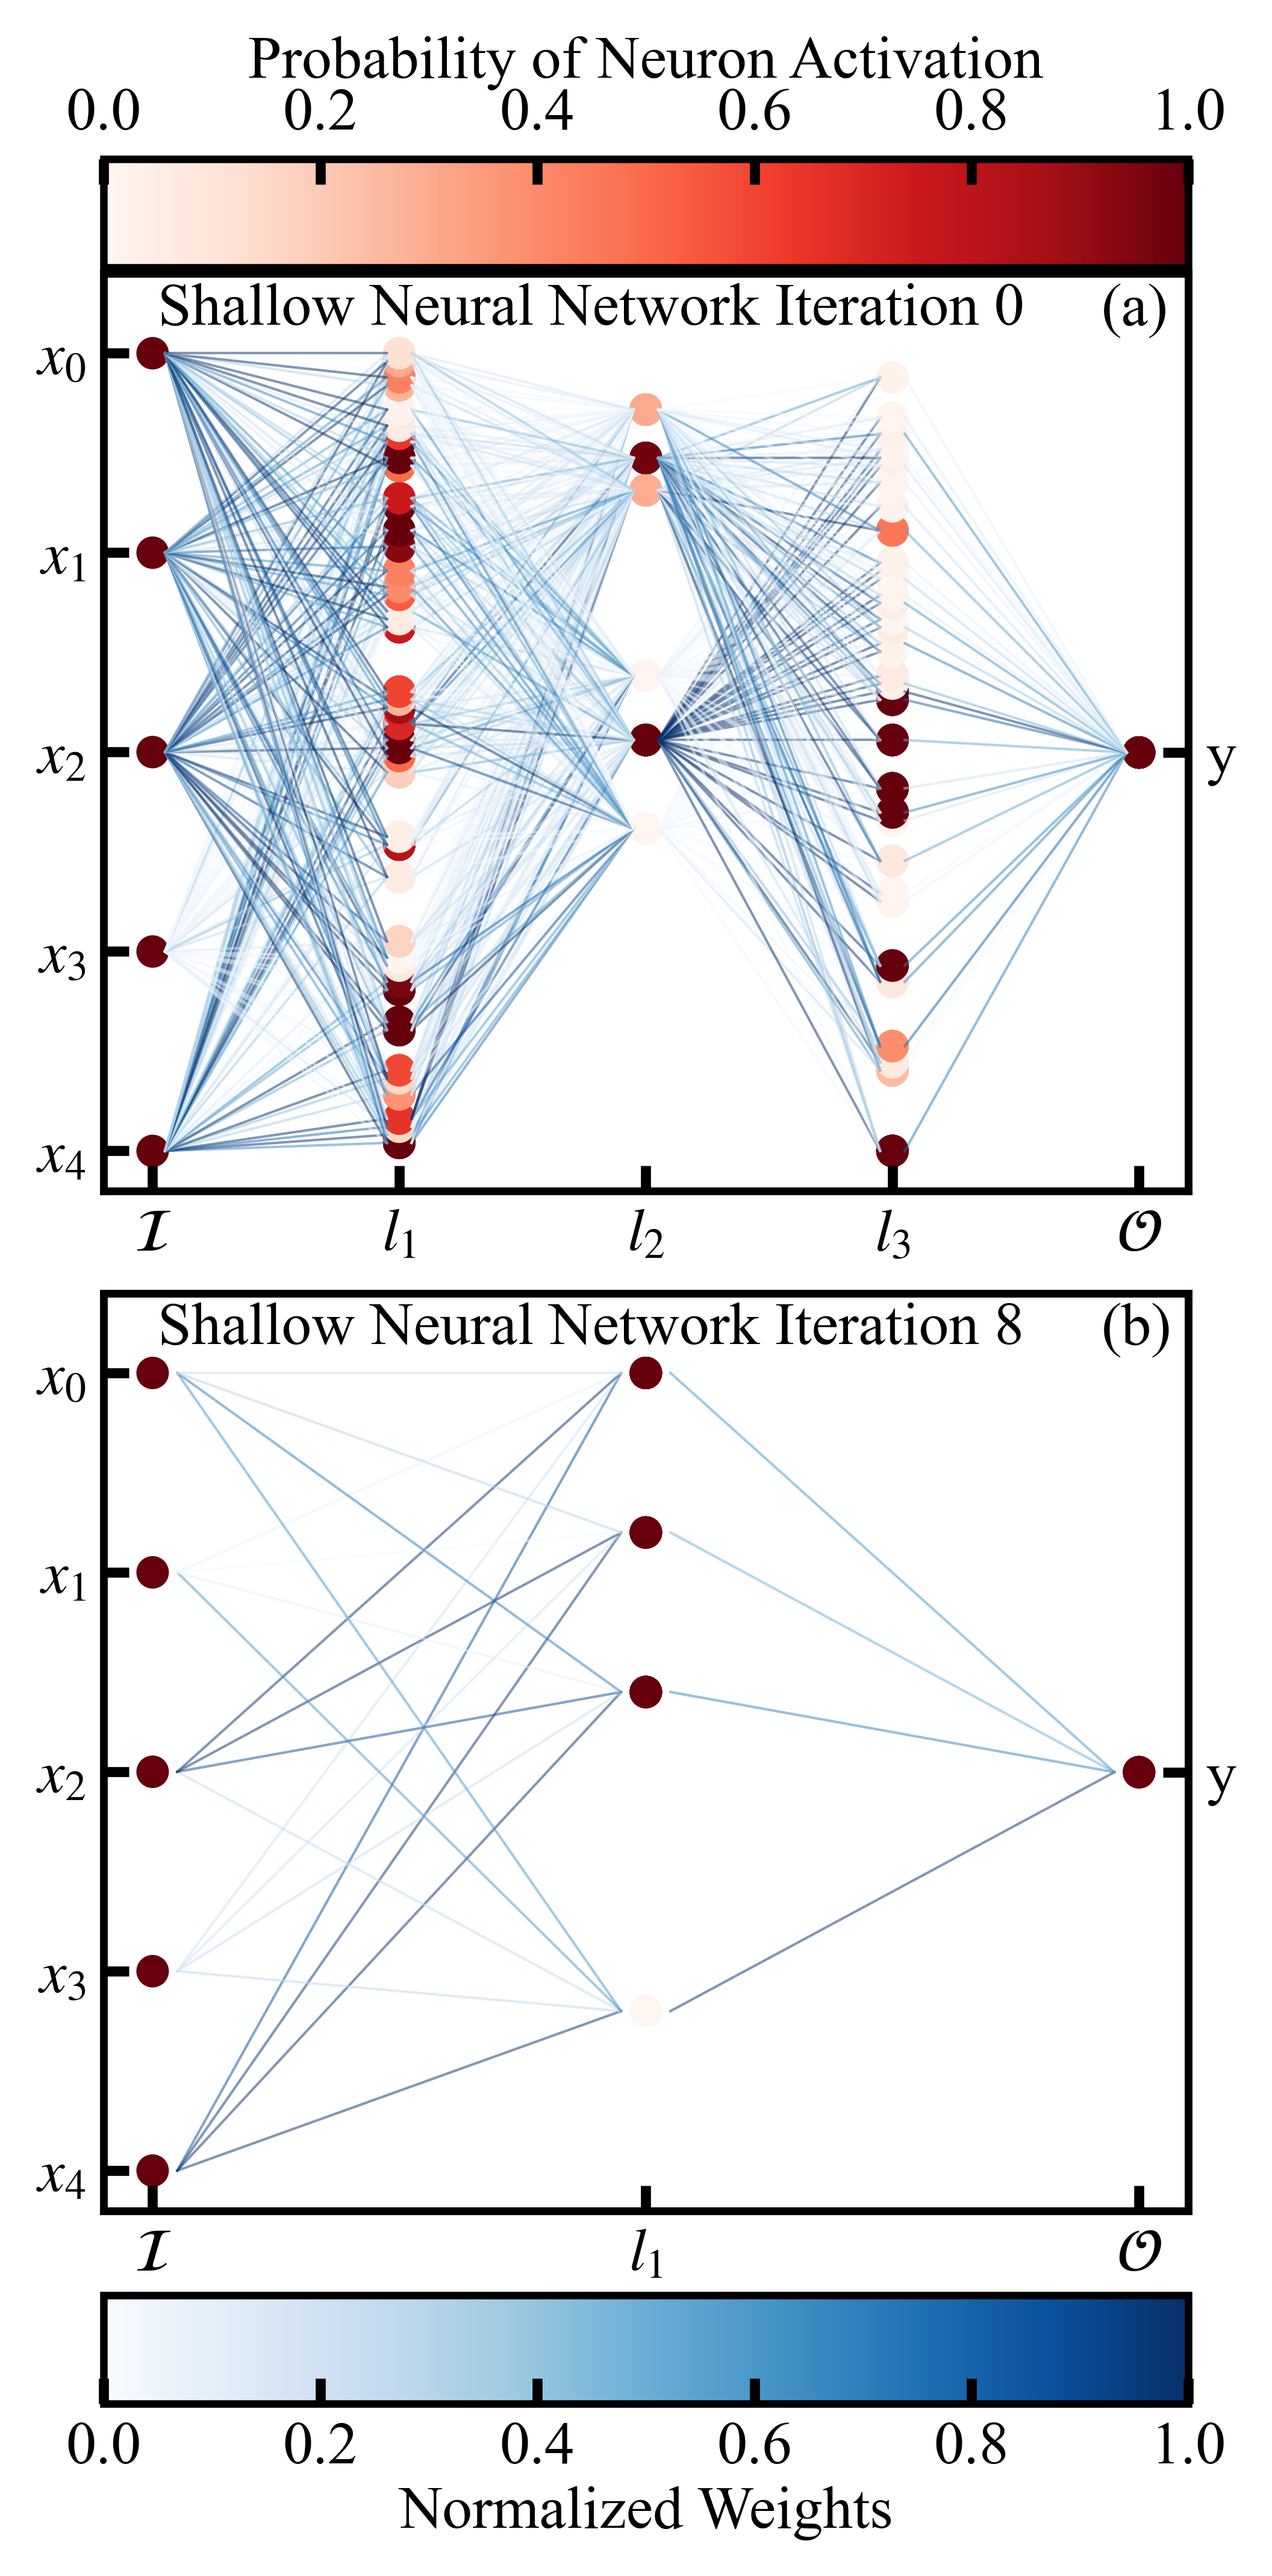

In [205]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(246.0, 0.6)

nn_style = {'axes.labelsize': 12,
            'axes.linewidth' : 1.5,
            'font.size': 12,
            'font.family': 'Times New Roman',
            'mathtext.fontset': 'stix',
            'legend.fontsize': 12,
            'xtick.labelsize': 12,
            'ytick.labelsize': 12,
            'text.usetex': False,
            'lines.linewidth': 1,
            'lines.linestyle': ' ',
            'lines.markersize' : 6,
            'lines.markeredgewidth' : 1,
            'xtick.major.size' : 5,
            'xtick.minor.size' : 0,
            'xtick.major.width' : 2,
            'xtick.minor.width' : 0,
            'xtick.direction' : 'in',
            'ytick.major.size' : 5,
            'ytick.minor.size' : 0,
            'ytick.major.width' : 2,
            'ytick.minor.width' : 0,
            'ytick.direction' : 'in',
            'xtick.minor.visible' : True,
            'ytick.minor.visible' : True,
            'savefig.transparent': True,
            'errorbar.capsize': 1.5,
            }


plt.rcParams.update(nn_style)
plt.rcParams.update({'figure.figsize': fig_size})
fig = plt.figure(dpi=600,constrained_layout=True)
# ax1 = plt.subplot(111)
ax2 = plt.subplot(211)
ax3 = plt.subplot(212)
# fig.set_constrained_layout_pads(w_pad=0.0,wspace=0.0)

dnn_features = ["jet_pt_raw","jet_nparts","jet_area","jet_angularity","jet_track_pt_0",
                        "jet_track_pt_1","jet_track_pt_2","jet_track_pt_3","jet_track_pt_4",
                        "jet_track_pt_5","jet_track_pt_6","jet_track_pt_7"]
dnn_features_tex =  [r'$p_{\mathrm{T,raw}}$',  r'$N_{\mathrm{track}}$', r'$A_{\mathrm{jet}}$', r'$\lambda_{\alpha=1}$', r'$p_{\mathrm{T,track}}^{0}$',
                        r'$p_{\mathrm{T,track}}^{1}$', r'$p_{\mathrm{T,track}}^{2}$', r'$p_{\mathrm{T,track}}^{3}$', r'$p_{\mathrm{T,track}}^{4}$',
                        r'$p_{\mathrm{T,track}}^{5}$', r'$p_{\mathrm{T,track}}^{6}$', r'$p_{\mathrm{T,track}}^{7}$']
dnn_features_tex= [r"$x_{%d}$"%i for i in range(len(dnn_features)-1,-1,-1)]
target='jet_pt_truth'
target_tex = r'$p_{\mathrm{T,truth}}$'
target_tex = r'y'
dnn_layer_labels = [r'$\mathcal{I}$',r'$l_1$',r'$l_2$',r'$l_3$',r'$\mathcal{O}$']
snn_layer_labels = [r'$\mathcal{I}$',r'$l_1$',r'$l_2$',r'$l_3$',r'$\mathcal{O}$']
snn_layer_iteration8 = [r'$\mathcal{I}$',r'$l_1$',r'$\mathcal{O}$']

# for A, B, W in zip(ALLPLOTS['dnn']['iXY'], ALLPLOTS['dnn']['fXY'], ALLPLOTS['dnn']['lineW'].tolist()):
#         ax1.plot([A[0]+0.05, B[0]-0.05], [A[1], B[1]], c=cm.Blues(W), linewidth=0.5, alpha=0.5,linestyle='-')
# ax1.scatter(ALLPLOTS['dnn']['nodeXY'][:,0],ALLPLOTS['dnn']['nodeXY'][:,1],c=ALLPLOTS['dnn']['nodeW'],cmap=cm.Reds,s=30,alpha=1.0)
# ax1.set_yticks(ALLPLOTS['dnn']['nodeXY'][:,1][ALLPLOTS['dnn']['nodeXY'][:,0] == 1])
# ax1.set_yticklabels(dnn_features_tex)
# ax1.set_ylim(-100,2100)
# ax1tw = ax1.twinx()
# ax1tw.set_ylim(ax1.get_ylim())
# ax1tw.set_yticks([ALLPLOTS['dnn']['nodeXY'][:,1][-1]], minor=False)
# ax1tw.set_yticklabels([target_tex])
# ax1.set_xticks(np.arange(1, len(dnn_layer_labels)+1), minor=False)
# ax1.set_xticklabels(dnn_layer_labels)


snn_features=['jet_angularity', 'jet_area', 'jet_pt_raw',  'jet_nparts', 'jet_track_pt_0']
snn_features_tex = [r'$\lambda_{\alpha=1}$', r'$A_{\mathrm{jet}}$', r'$p_{\mathrm{T,raw}}$', r'$N_{\mathrm{track}}$', r'$p_{\mathrm{T,track}}^{0}$']
target='jet_pt_truth'

snn_features_tex= [r"$x_{%d}$"%i for i in range(len(snn_features)-1,-1,-1)]

for A, B, W in zip(PLOTSSNN['iteration0']['iXY'], PLOTSSNN['iteration0']['fXY'], PLOTSSNN['iteration0']['lineW'].tolist()):
        ax2.plot([A[0]+0.05, B[0]-0.05], [A[1], B[1]], c=cm.Blues(W), linewidth=0.5, alpha=0.5,linestyle='-')
ax2.scatter(PLOTSSNN['iteration0']['nodeXY'][:,0],PLOTSSNN['iteration0']['nodeXY'][:,1],c=PLOTSSNN['iteration0']['nodeW'],cmap=cm.Reds,s=30,alpha=1.0)
ax2.set_yticks(PLOTSSNN['iteration0']['nodeXY'][:,1][PLOTSSNN['iteration0']['nodeXY'][:,0] == 1])
ax2.set_yticklabels(snn_features_tex)
ax2.set_ylim(-100,2200)
ax2tw = ax2.twinx()
ax2tw.set_ylim(ax2.get_ylim())
ax2tw.set_yticks([PLOTSSNN['iteration0']['nodeXY'][:,1][-1]])
ax2tw.set_yticklabels([target_tex])
ax2.set_xticks(np.arange(1, len(snn_layer_labels)+1))
ax2.set_xticklabels(snn_layer_labels)


for A, B, W in zip(PLOTSSN2LAYERS['iteration0']['iXY'], PLOTSSN2LAYERS['iteration0']['fXY'], PLOTSSN2LAYERS['iteration0']['lineW'].tolist()):
        ax3.plot([A[0]+0.05, B[0]-0.05], [A[1], B[1]], c=cm.Blues(W), linewidth=0.5, alpha=0.5,linestyle='-')
ax3.scatter(PLOTSSN2LAYERS['iteration0']['nodeXY'][:,0],PLOTSSN2LAYERS['iteration0']['nodeXY'][:,1],c=PLOTSSN2LAYERS['iteration0']['nodeW'],cmap=cm.Reds,s=30,alpha=1.0)
ax3.set_yticks(PLOTSSN2LAYERS['iteration0']['nodeXY'][:,1][PLOTSSN2LAYERS['iteration0']['nodeXY'][:,0] == 1])
ax3.set_yticklabels(snn_features_tex)
ax3.set_ylim(-100,2200)
ax3tw = ax3.twinx()
ax3tw.set_ylim(ax3.get_ylim())
ax3tw.set_yticks([PLOTSSN2LAYERS['iteration0']['nodeXY'][:,1][-1]])
ax3tw.set_yticklabels([target_tex])
ax3.set_xticks(np.arange(1, len(snn_layer_iteration8)+1))
ax3.set_xticklabels(snn_layer_iteration8)

xi = 0.02 
xw = 1.0 - 2*xi + 0.001
yi = -0.3
yh = 1.0 - 2*yi+0.001
cax = fig.add_axes([xi, yi, xw, yh])
cax.set_visible(False)

# ax1.text(0.3, 0.99, r'Sparse Deep Neural Network', transform=ax1.transAxes, fontsize=12, va='top', ha='left')
# ax1.text(0.92, 0.99, r'(a)', transform=ax1.transAxes, fontsize=12, va='top', ha='left')
ax2.text(0.05, 0.99, r'Shallow Neural Network Iteration 0', transform=ax2.transAxes, fontsize=12, va='top', ha='left')
ax2.text(0.92, 0.99, r'(a)', transform=ax2.transAxes, fontsize=12, va='top', ha='left')
# ax2.text(0.05, 0.93, r'Iteration 0', transform=ax2.transAxes, fontsize=12, va='top', ha='left')
ax3.text(0.05, 0.99, r'Shallow Neural Network Iteration 8', transform=ax3.transAxes, fontsize=12, va='top', ha='left')
ax3.text(0.92, 0.99, r'(b)', transform=ax3.transAxes, fontsize=12, va='top', ha='left')
# ax3.text(0.05, 0.93, r'Iteration 8', transform=ax3.transAxes, fontsize=12, va='top', ha='left')
plt.cbar = plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap='Reds'), ax=ax2, location='top',pad=0.01, aspect=10,anchor=(0.0,1.0))
plt.cbar.set_label('Probability of Neuron Activation', rotation=0, labelpad=2)
plt.cbar = plt.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap='Blues'), ax=ax3, location='bottom',pad=0.01, aspect=10,anchor=(0.0,1.0))
plt.cbar.set_label('Normalized Weights', rotation=0, labelpad=2)


plt.show()
fig.savefig('pdf/snn_plot.pdf', bbox_inches='tight')
fig.savefig('png/snn_plot.png', bbox_inches='tight')